# Augmentation
This notebook aims to help gain a better understanding of augmentation by training a model without augmentation and then training a model with augmentation to see the effects of augmentation on the training and test errors of a neural network model

### Imports
Import all the libraries needed to define the augmentation function and the neural network model as well as train the neural network model

In [1]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random

### Define Dataset
Import the dataset and store it in their respective variables

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

Successfully loaded data from ./mnist1d_data.pkl


### Define Hyperparameters
Define the hyperparameters (input, hidden, output dimensions) of the neural network model

In [3]:
D_i = 40    # Input dimensions
D_k = 200   # Hidden dimensions
D_o = 10    # Output dimensions

### Define Neural Network Model
Define a neural network model with two hidden layers, where each layer consists of 200 hidden units

In [4]:
model = nn.Sequential(
nn.Linear(D_i, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_o))

### Define Weight Initialization Function
Define a function that initializes the weight (parameter) values of the neural network model

In [5]:
def weights_init(layer_in):
  # Initialize the parameters with He initialization
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Define Cross Entropy Loss Function
Define the cross entropy loss function as the chosen loss function for this neural network model

In [6]:
loss_function = torch.nn.CrossEntropyLoss()

### Define Stochastic Gradient Descent Function
Define the stochastic gradient descent step function as the chosen back propagation algorithm for this neural network, which also takes learning rate and momentum as its parameters

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

### Define Learning Rate Adjustment Variable
Define a scheduler, which adjusts the learning rate of the neural network model by decreasining the learning rate by half every 10 epochs 

In [8]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

### Format Training and Test Data
Convert the training and test data into proper format for training the neural network model

In [9]:
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

### Batch Training and Test Data
Convert the formatted training and test data into batches for the stochastic gradient descent step function

In [10]:
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

### Initialize Neural Network Model Weights

In [11]:
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

### Define Epochs
Define the number of times to loop over the entire dataset during training

In [12]:
n_epoch = 50

### Define Loss and % Correct Array Structure
Define an array structure that stores the values for the loss and % correct of the neural network model at each epoch

In [13]:
errors_train = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

### Compute Backpropagation
Compute backpropagation for each batch of data and calculate the statistics (loss and % correct) for that backpropagation

In [14]:
for epoch in range(n_epoch):
  # Loop over batches
  for i, batch in enumerate(data_loader):
    # Retrieve inputs and labels for the batch
    x_batch, y_batch = batch
    # Reset the parameter gradients to zero
    optimizer.zero_grad()
    # Calculate forward pass and model output
    pred = model(x_batch)
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Compute backward pass
    loss.backward()
    # Undergo the SGD 
    optimizer.step()

  # Compute statistics for this epoch
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train[epoch]:3.2f}, test error {errors_test[epoch]:3.2f}')


Epoch     0, train error 57.78, test error 64.75
Epoch     1, train error 46.20, test error 53.70
Epoch     2, train error 39.12, test error 50.35
Epoch     3, train error 31.00, test error 45.72
Epoch     4, train error 24.25, test error 44.40
Epoch     5, train error 19.05, test error 40.65
Epoch     6, train error 16.43, test error 41.15
Epoch     7, train error 11.10, test error 38.83
Epoch     8, train error 10.10, test error 37.78
Epoch     9, train error 6.97, test error 38.38
Epoch    10, train error 4.47, test error 37.50
Epoch    11, train error 2.43, test error 37.15
Epoch    12, train error 2.03, test error 36.08
Epoch    13, train error 0.78, test error 35.90
Epoch    14, train error 0.47, test error 35.70
Epoch    15, train error 0.07, test error 35.72
Epoch    16, train error 0.12, test error 35.28
Epoch    17, train error 0.00, test error 35.28
Epoch    18, train error 0.00, test error 35.32
Epoch    19, train error 0.00, test error 35.03
Epoch    20, train error 0.00, 

### Plot Test and Training Error
Plot the final test error and training error of the neural network model

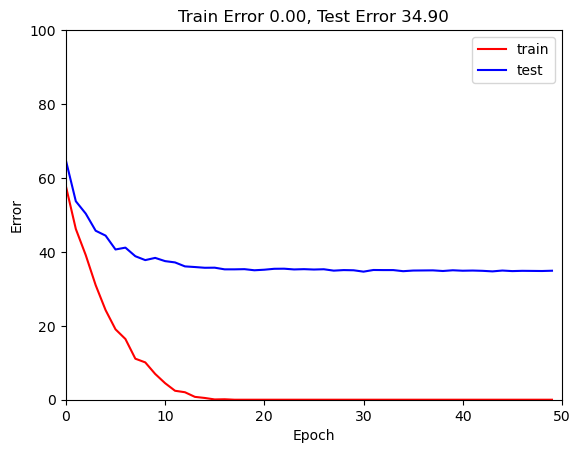

In [15]:
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Train Error %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

## Augmentation

## Define Augmentation Function
Define a function that augments the main dataset (makes subsets of the main dataset and offsets the data by an integer)

In [16]:
def augment(input_vector):
  # Define array structure for output
  data_out = np.zeros_like(input_vector)

  # Offset the data by a random integer
  data_out = np.roll(input_vector, random.randint(1, len(input_vector) - 1))

  # Randomly scale each data point by a factor randomly chosen from [0.8, 1.2]
  data_out = np.random.uniform(0.8, 1.2, size = data_out.shape)*data_out

  return data_out

### Define Dataset Array
Define an array that stores the input values of the original data

In [17]:
n_data_orig = data['x'].shape[0]

### Define Number of Data after Augmentation
Define the total number of data that we want to be present after augmentation of the original data

In [18]:
n_data_augment = n_data_orig+4000

### Define Augmented Data Array Structure
Define the augmented data array structure, which stores the augmented data as well as the original data

In [19]:
augmented_x = np.zeros((n_data_augment, D_i))
augmented_y = np.zeros(n_data_augment)
augmented_x[0:n_data_orig,:] = data['x']
augmented_y[0:n_data_orig] = data['y']

### Augment Dataset
Loop over the entire dataset and augment each data point

In [20]:
for c_augment in range(n_data_orig, n_data_augment):
  # Choose a random data point
  random_data_index = random.randint(0, n_data_orig-1)
  # Augment the point and store it in the augmented data array
  augmented_x[c_augment,:] = augment(data['x'][random_data_index,:])
  augmented_y[c_augment] = data['y'][random_data_index]

### Define Cross Entropy Loss Function
Define the cross entropy loss function as the chosen loss function for this neural network model

In [21]:
loss_function = torch.nn.CrossEntropyLoss()

### Define Stochastic Gradient Descent Function
Define the stochastic gradient descent step function as the chosen back propagation algorithm for this neural network, which also takes learning rate and momentum as its parameters

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

### Define Learning Rate Adjustment Variable
Define a scheduler, which adjusts the learning rate of the neural network model by decreasining the learning rate by half every 10 epochs 

In [23]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

### Format Training and Test Data
Convert the training and test data into proper format for training the neural network model

In [24]:
x_train = torch.tensor(augmented_x.astype('float32'))
y_train = torch.tensor(augmented_y.transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

### Batch Training and Test Data
Convert the formatted training and test data into batches for the stochastic gradient descent step function

In [25]:
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

### Initialize Model Weights

In [26]:
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

### Define Epochs
Define the number of times to loop over the entire dataset

In [27]:
n_epoch = 50

### Define Loss and % Correct Array Structures
Define array structures that store the loss and % correct of the neural network model at each epoch

In [28]:
errors_train_aug = np.zeros((n_epoch))
errors_test_aug = np.zeros((n_epoch))

### Compute Backpropagation
Compute backpropagation for each batch of data and calculate the statistics (loss and % correct) for that backpropagation

In [29]:
for epoch in range(n_epoch):
  # Loop over batches
  for i, batch in enumerate(data_loader):
    # Retrieve inputs and labels for the batch
    x_batch, y_batch = batch
    # Reset the parameter gradients to zero
    optimizer.zero_grad()
    # Compute the forward pass and the model output
    pred = model(x_batch)
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Compute the backward pass
    loss.backward()
    # Undergo the SGD
    optimizer.step()

  # Compute statistics for this epoch
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train_aug[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test_aug[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train_aug[epoch]:3.2f}, test error {errors_test_aug[epoch]:3.2f}')


Epoch     0, train error 55.85, test error 58.28
Epoch     1, train error 44.90, test error 50.28
Epoch     2, train error 36.81, test error 45.10
Epoch     3, train error 31.22, test error 41.33
Epoch     4, train error 27.54, test error 40.70
Epoch     5, train error 23.10, test error 39.15
Epoch     6, train error 19.96, test error 37.30
Epoch     7, train error 16.65, test error 36.90
Epoch     8, train error 16.19, test error 37.12
Epoch     9, train error 13.78, test error 36.55
Epoch    10, train error 11.30, test error 35.47
Epoch    11, train error 8.91, test error 34.62
Epoch    12, train error 8.41, test error 35.93
Epoch    13, train error 5.01, test error 34.12
Epoch    14, train error 3.80, test error 33.95
Epoch    15, train error 3.22, test error 33.65
Epoch    16, train error 2.64, test error 33.18
Epoch    17, train error 1.84, test error 32.80
Epoch    18, train error 1.07, test error 33.12
Epoch    19, train error 0.36, test error 33.47
Epoch    20, train error 0.19

### Plot Test and Training Error
Plot the final test error and training error of the neural network model

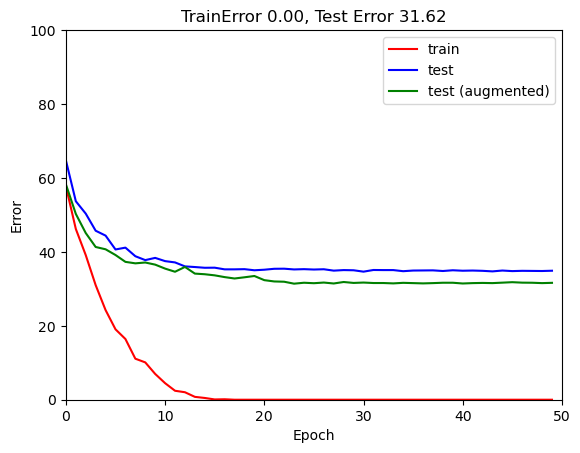

In [30]:
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.plot(errors_test_aug,'g-',label='test (augmented)')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train_aug[-1],errors_test_aug[-1]))
ax.legend()
plt.show()